## Ex 4.10

### Part 3
##### - a) Creating customer (Cx) profiles based on Age-Income as well as Family Details -Incomes
##### - b) Showcase Cx profile distribution using visualizations
##### - c) Overview of aggregtation statistics for order_frequency and order_totals (expenditure) for each Cx profile
### Part 4
##### - a) Cx profile comparisions: Region, Deapartment, Product Price Range
##### - b) Comparison Visualizations
##### - c) Other stakeholder questions
- How do customer profiles impact loyalty and spending type?
- Are there certain types of products that are more popular than others? The marketing and sales teams want to know which departments have the highest frequency of product orders.
- quote: InstaCart Cx "I want to receive ads, promotions, and recommendations that are relevant to the products I order regularly" - Suggestion, create a new column which identifies a particular User_ids most shopped for department, so that the marketting team can tailor ad campaigns that boost revenue and order frequency

In [1]:
#Re-importing libraries and data sets
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
path = r'C:\Users\mojos\OneDrive\Career Foundry Course\Task4 - InstaCart Project'

In [3]:
ha_ords_prods_custs = pd.read_pickle(os.path.join(path,'02 Data','Prepared Data','ha_ords_prods_custs_w_dep.pkl'))

### Part 3 a) Creating Cx Profiles

#### Defining groupings based on customer characteristics:
Chosen criteria:

(1) Age + Income description
- age based descriptors. Definitions taken from google search top result, https://www.sciencedirect.com (Young adulthood: 18-39, Middle adulthood: 40-59, old adulthood: 60+)
- Income brackets based on US values taken from https://finance.yahoo.com (top google search at time of writing)(Lower-Income: 48,500, Middle-Income: 48,500-145,500 , Upper-Income: 145,500)


(2) Household type + Income description
- Family/Household situation, defined by whether a user is single/married, and whether they have dependants (which could be anyone under their care, so we can't generalize this to mean kids) (leveraging existing columns)
- Income Brackets (same as above)

In [4]:
ha_ords_prods_custs.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'orders_day_of_week',
       'order_hour_of_day', 'days_since_prior_order', 'first_order',
       'product_id', 'add_to_cart_order', 'reordered', 'product_name',
       'aisle_id', 'department_id', 'prices', 'price_range_loc',
       'busiest_days', 'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'mean_price', 'cx_spend_type', 'order_frequency', 'cx_order_frequency',
       'Gender', 'STATE', 'Age', 'date_joined', 'n_dependants', 'fam_status',
       'income', '_merge', 'department_x', 'region', 'low_activity', 'level_1',
       'most_freq_department'],
      dtype='object')

#### Dropping some non-essential columns to reduce memory requirements.
- _merge
- 'level_1'
#### Final renaming of any columns to avoid confusion.
- 'cx_order_frequency' to 'cx_frequency_type'
- 'department_x' to ''department'

In [5]:
ha_ords_prods_custs = ha_ords_prods_custs.drop(columns = ['_merge','level_1'])

In [6]:
ha_ords_prods_custs = ha_ords_prods_custs.rename(columns = {'cx_order_frequency':'cx_frequency_type'})

In [7]:
ha_ords_prods_custs = ha_ords_prods_custs.rename(columns = {'department_x':'department'})

#### Defining the age gouping using .loc

In [8]:
ha_ords_prods_custs.loc[ha_ords_prods_custs['Age']<=39, 'age_description'] = 'Young'

In [9]:
ha_ords_prods_custs.loc[(ha_ords_prods_custs['Age']>=40) & (ha_ords_prods_custs['Age']<=59), 'age_description'] = 'Middle Age'

In [10]:
ha_ords_prods_custs.loc[ha_ords_prods_custs['Age']>=60, 'age_description'] = 'Old Age'

In [11]:
ha_ords_prods_custs['age_description'].value_counts(dropna = False)

age_description
Young         10665110
Old Age       10574504
Middle Age     9724950
Name: count, dtype: int64

#### Defining the income grouping using .loc

In [12]:
ha_ords_prods_custs.loc[ha_ords_prods_custs['income']<=48500, 'income_description'] = 'Low Income'

In [13]:
ha_ords_prods_custs.loc[(ha_ords_prods_custs['income']>=48501) & (ha_ords_prods_custs['income']<=145499), 'income_description'] = 'Middle Income'

In [14]:
ha_ords_prods_custs.loc[ha_ords_prods_custs['income']>=145500, 'income_description'] = 'Upper Income'

In [15]:
ha_ords_prods_custs['income_description'].value_counts(dropna = False)

income_description
Middle Income    23128350
Upper Income      4690090
Low Income        3146124
Name: count, dtype: int64

In [16]:
#concatennating the new string grouping values to use as a single column
ha_ords_prods_custs ['age_income_combined'] = ha_ords_prods_custs['age_description'] + [' '] + ha_ords_prods_custs['income_description']

In [17]:
ha_ords_prods_custs['age_income_combined'].value_counts(dropna = False)

age_income_combined
Young Middle Income         9001355
Old Age Middle Income       7335887
Middle Age Middle Income    6791108
Old Age Upper Income        2433118
Middle Age Upper Income     2152092
Young Low Income            1558875
Old Age Low Income           805499
Middle Age Low Income        781750
Young Upper Income           104880
Name: count, dtype: int64

#### Defining the Household grouping using .loc (2 steps, creating a definition for single/married, and turning depandant int64 value into a string discription for with 'depandants', 'no dependants')

In [18]:
#Confirming the current options listed in the dataframe for family type
ha_ords_prods_custs['fam_status'].value_counts(dropna=True)

fam_status
married                             21743711
single                               5094410
divorced/widowed                     2645271
living with parents and siblings     1481172
Name: count, dtype: int64

#### Based on the values indicated above, the following logic will be employed:
- Married, considered it's own grouping
- Single, considered part of the grouping 'single'
- Divorced/widowed, also considered part of the group 'single'
- living with parents and siblings, whilst tricky to define in the context of this analysis, this group will be considered 'single' (with dependants).

In [19]:
#To streamline the generation of the definitions of household we can use .loc. I used == Married and != as a catch all, because otherwise we'd have to write twice as many scripts to account for the variable value differences.
ha_ords_prods_custs.loc[(ha_ords_prods_custs['fam_status']=='married') & (ha_ords_prods_custs['n_dependants']<1), 'household_type'] = 'Married: No Dependants'
ha_ords_prods_custs.loc[(ha_ords_prods_custs['fam_status']=='married') & (ha_ords_prods_custs['n_dependants']>=1), 'household_type'] = 'Married: w Dependants'
ha_ords_prods_custs.loc[(ha_ords_prods_custs['fam_status']!='married') & (ha_ords_prods_custs['n_dependants']<1), 'household_type'] = 'Single: No Dependants'
ha_ords_prods_custs.loc[(ha_ords_prods_custs['fam_status']!='married') & (ha_ords_prods_custs['n_dependants']>=1), 'household_type'] = 'Single: w Dependants'

In [20]:
ha_ords_prods_custs['household_type'].value_counts()

household_type
Married: w Dependants    21743711
Single: No Dependants     7739681
Single: w Dependants      1481172
Name: count, dtype: int64

#### Combining out put of the household_type with the income bracket column

In [21]:
ha_ords_prods_custs ['household_income_combined'] = ha_ords_prods_custs['household_type'] + [' '] + ha_ords_prods_custs['income_description']

In [22]:
ha_ords_prods_custs ['household_income_combined'].value_counts()

household_income_combined
Married: w Dependants Middle Income    16107198
Single: No Dependants Middle Income     5761858
Married: w Dependants Upper Income      3485855
Married: w Dependants Low Income        2150658
Single: w Dependants Middle Income      1259294
Single: No Dependants Upper Income      1188906
Single: No Dependants Low Income         788917
Single: w Dependants Low Income          206549
Single: w Dependants Upper Income         15329
Name: count, dtype: int64

### Part 3 b) Cx Profile Distribution

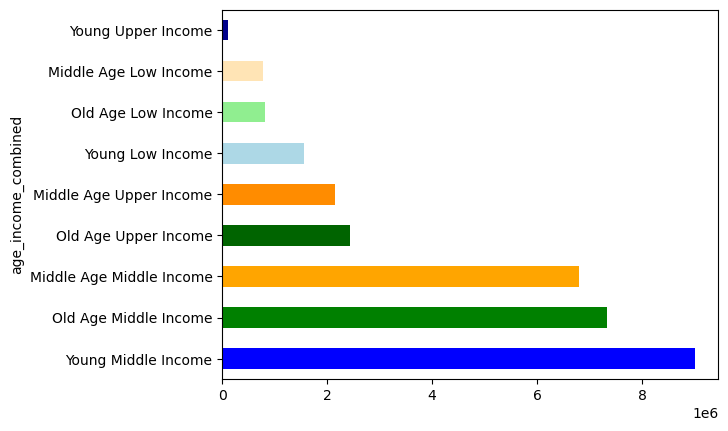

In [133]:
#Creating a bar chart that shows the frequency of each grouping - colours are coded by age group, with an alternate shade for their income level (light, normal, dark for low,middle,upper respectively)
age_income_distribution = ha_ords_prods_custs['age_income_combined'].value_counts().plot.barh(color = ['blue','green','orange','darkgreen','darkorange','lightblue','lightgreen','moccasin','darkblue'])

In [134]:
#exporting bar chart output
age_income_distribution.figure.savefig('C:\\Users\\mojos\\OneDrive\\Career Foundry Course\\Task4 - InstaCart Project\\04 Analysis\\Visualizations\\age_income_distribution.png',bbox_inches='tight')

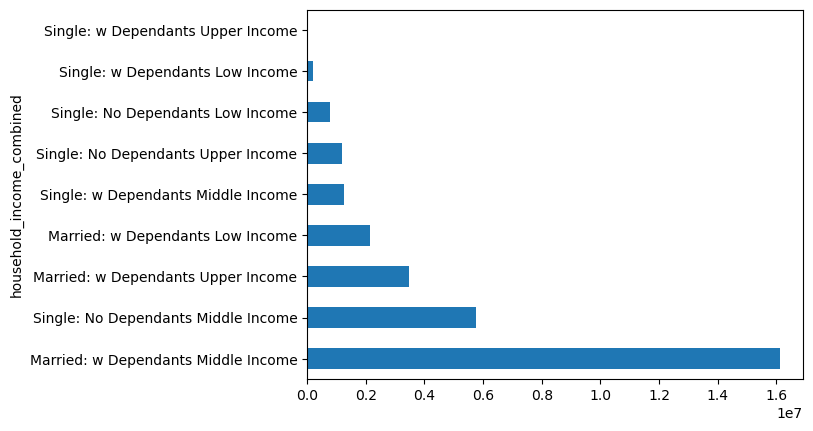

In [131]:
#Creating a bar chart that shows the frequency of each grouping in the 'household_income' column
household_income_distribution = ha_ords_prods_custs['household_income_combined'].value_counts().plot.barh()

In [132]:
#exporting bar chart output
household_income_distribution.figure.savefig('C:\\Users\\mojos\\OneDrive\\Career Foundry Course\\Task4 - InstaCart Project\\04 Analysis\\Visualizations\\household_income_distribution.png',bbox_inches='tight')

### Part 3 c) Aggegation for min / max /mean on usage frequency and expenditure.

In [27]:
#order_frequency is already a numeric value that we can use to find out min/max/mean values - the value represents the average time between orders per customer.
ha_ords_prods_custs.groupby('age_income_combined').agg({'order_frequency': ['count','mean', 'min', 'max']})

order_frequency                      
                                   count       mean  min   max
age_income_combined                                           
Middle Age Low Income             781750  10.629846  0.0  30.0
Middle Age Middle Income         6791108   9.939526  0.0  30.0
Middle Age Upper Income          2152092   9.839538  0.0  30.0
Old Age Low Income                805499  10.433045  0.0  30.0
Old Age Middle Income            7335887   9.948861  0.0  30.0
Old Age Upper Income             2433118   9.797606  0.0  30.0
Young Low Income                 1558875  10.558236  0.0  30.0
Young Middle Income              9001355   9.848118  0.0  30.0
Young Upper Income                104880   9.544217  2.0  30.0

#### Nothing particularly surprising about the decriptive stats provided by the commands output - It's interesting to see that the mean order frequency between groups is all within a 1 day range.  No group in particular has a drastically more frequent order rate than the other.

In [28]:
ha_ords_prods_custs.groupby('household_income_combined').agg({'order_frequency': ['count','mean', 'min', 'max']})

order_frequency                      
                                              count       mean  min   max
household_income_combined                                                
Married: w Dependants Low Income            2150658  10.560820  0.0  30.0
Married: w Dependants Middle Income        16107198   9.918854  0.0  30.0
Married: w Dependants Upper Income          3485855   9.844309  0.0  30.0
Single: No Dependants Low Income             788917  10.484920  0.0  30.0
Single: No Dependants Middle Income         5761858   9.902030  0.0  30.0
Single: No Dependants Upper Income          1188906   9.740090  0.0  30.0
Single: w Dependants Low Income              206549  10.594167  0.0  30.0
Single: w Dependants Middle Income          1259294   9.776489  0.0  30.0
Single: w Dependants Upper Income             15329   7.791474  2.0  30.0

#### The results of this profile are a little more interesting. The mean for single w/ dependants upper income is almost 2 days off from the next closest grouping (which is also single upper income, though with no dependants) We can't ascertain the cause as of yet - but perhaps it will become clear following additional analysis.

#### Generating the min / max / mean on expediture is a little different, because we need to know the sum of each order placed by the client. Mean expenditure for example should represent average order price, rather than mean product price

In [29]:
#Generating the same values for expenditure: to define expenditure we need to recreate a 'total_order_value' column.
df = ha_ords_prods_custs.groupby('order_id').agg({'prices':'sum'})

In [30]:
df = df.reset_index()

In [31]:
df2 = ha_ords_prods_custs[['order_id','region','age_income_combined','household_income_combined']]

In [32]:
df2.shape

(30964564, 4)

In [33]:
#we only need a list that has each order_id and their user details once, so creating a dupe subset.
df2_dupes = df2.drop_duplicates('order_id')

In [34]:
df2.size

123858256

In [35]:
df2_dupes.size

12257500

In [36]:
df_merge = df.merge(df2_dupes,how='left',on = 'order_id')

In [37]:
df_merge.head()

,order_id,prices,region,age_income_combined,household_income_combined
0,2,91.6,West,Middle Age Middle Income,Married: w Dependants Middle Income
1,3,70.3,West,Middle Age Upper Income,Married: w Dependants Upper Income
2,4,92.8,Northeast,Old Age Middle Income,Married: w Dependants Middle Income
3,5,210.7,South,Young Middle Income,Married: w Dependants Middle Income
4,6,27.5,Midwest,Young Middle Income,Married: w Dependants Middle Income


In [38]:
df_merge.groupby('age_income_combined').agg({'prices': ['count','mean', 'min', 'max']})

prices                        
                           count       mean  min     max
age_income_combined                                     
Middle Age Low Income     104488  48.831206  1.0   712.0
Middle Age Middle Income  657602  81.479282  1.0  1092.2
Middle Age Upper Income   203120  84.137947  1.0  1047.4
Old Age Low Income        107690  48.735113  1.0   875.0
Old Age Middle Income     710358  81.426860  1.0   787.0
Old Age Upper Income      231856  83.424463  1.0   751.1
Young Low Income          189660  56.284650  1.0   694.4
Young Middle Income       850336  84.120280  1.0   842.1
Young Upper Income          9265  88.558737  1.0   669.3

In [39]:
#Creating a bar chart to plot the mean values from the above output
barplot_df = df_merge.groupby('age_income_combined').agg({'prices': 'mean'})

In [40]:
barplot_df

,prices
age_income_combined,
Middle Age Low Income,48.831206
Middle Age Middle Income,81.479282
Middle Age Upper Income,84.137947
Old Age Low Income,48.735113
Old Age Middle Income,81.426860
Old Age Upper Income,83.424463
Young Low Income,56.284650
Young Middle Income,84.120280
Young Upper Income,88.558737


Text(0, 0.5, 'Average Order Total')

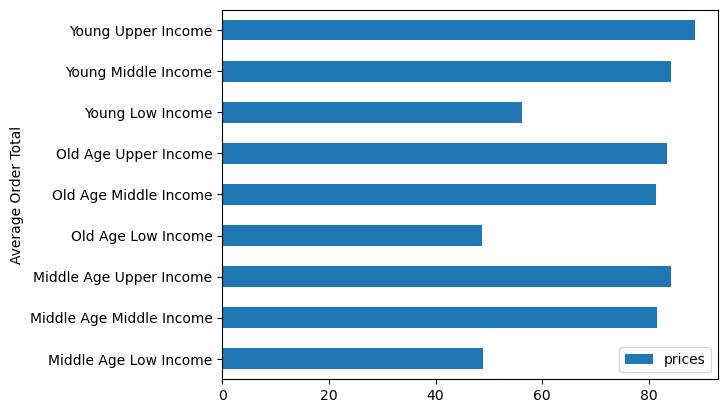

In [135]:
group_av_order = barplot_df.plot.barh()
plt.ylabel('Average Order Total')

In [136]:
group_av_order.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','age_income_av_order.png'), bbox_inches='tight')

In [43]:
df_merge.groupby('household_income_combined').agg({'prices': ['count','mean', 'min', 'max']})

prices                        
                                       count       mean  min     max
household_income_combined                                           
Married: w Dependants Low Income      276132  51.935297  1.0   628.2
Married: w Dependants Middle Income  1544604  82.446945  1.0  1092.2
Married: w Dependants Upper Income    330508  83.812444  1.0  1047.4
Single: No Dependants Low Income      100517  52.463041  1.0   875.0
Single: No Dependants Middle Income   554909  82.148548  1.0   736.7
Single: No Dependants Upper Income    112328  83.952658  1.0   621.2
Single: w Dependants Low Income        25189  56.019743  1.0   694.4
Single: w Dependants Middle Income    118783  84.362341  1.0   750.3
Single: w Dependants Upper Income       1405  86.933288  1.0   497.1

In [44]:
#Creating a bar chart to plot the mean values from the above output
barplot2_df = df_merge.groupby('household_income_combined').agg({'prices': 'mean'})

In [45]:
barplot2_df

,prices
household_income_combined,
Married: w Dependants Low Income,51.935297
Married: w Dependants Middle Income,82.446945
Married: w Dependants Upper Income,83.812444
Single: No Dependants Low Income,52.463041
Single: No Dependants Middle Income,82.148548
Single: No Dependants Upper Income,83.952658
Single: w Dependants Low Income,56.019743
Single: w Dependants Middle Income,84.362341
Single: w Dependants Upper Income,86.933288


Text(0, 0.5, 'Average Order Total')

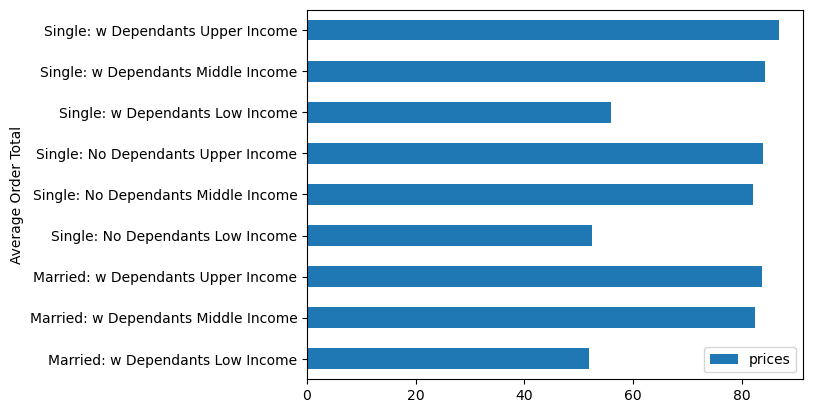

In [137]:
group2_av_order = barplot2_df.plot.barh()
plt.ylabel('Average Order Total')

In [138]:
group2_av_order.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','household_income_av_order.png'), bbox_inches='tight')

### Part 4 a) Regional, Department, & Price Range Comparisons

In [48]:
crosstab2 = pd.crosstab(ha_ords_prods_custs['region'],ha_ords_prods_custs['age_income_combined'],dropna=False)

In [49]:
crosstab2

age_income_combined,Middle Age Low Income,Middle Age Middle Income,Middle Age Upper Income,Old Age Low Income,Old Age Middle Income,Old Age Upper Income,Young Low Income,Young Middle Income,Young Upper Income
region,,,,,,,,,
Midwest,175386,1631547,516136,180258,1709999,565186,376833,2081941,24227
Northeast,136223,1195301,377195,143342,1311613,429274,268775,1584728,18234
South,262142,2226815,692514,279138,2417717,824566,527708,3043224,37315
West,207999,1737445,566247,202761,1896558,614092,385559,2291462,25104


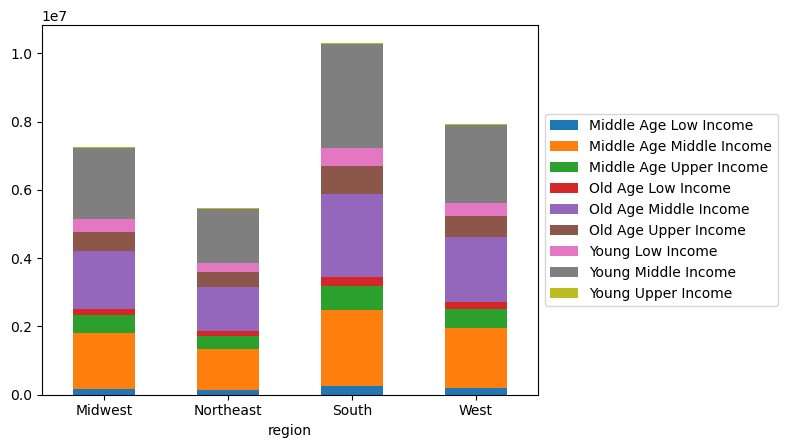

In [50]:
barplot_region_age_income = crosstab2.plot.bar(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [51]:
barplot_region_age_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_region_age_income.png'), bbox_inches='tight')

#### Observation: the proportionality of different customer profile groupings appears to follow the same general distribution across each region. The main take away is that the South has the largest population of users, and that in all regions, the 'middle income' proportion' of each age group contribute the largest to the overall data set population.

In [52]:
crosstab3 = pd.crosstab(ha_ords_prods_custs['region'],ha_ords_prods_custs['household_income_combined'],dropna=False)

In [53]:
crosstab3

household_income_combined,Married: w Dependants Low Income,Married: w Dependants Middle Income,Married: w Dependants Upper Income,Single: No Dependants Low Income,Single: No Dependants Middle Income,Single: No Dependants Upper Income,Single: w Dependants Low Income,Single: w Dependants Middle Income,Single: w Dependants Upper Income
region,,,,,,,,,
Midwest,506660,3750194,830408,179803,1370395,272618,46014,302898,2523
Northeast,373918,2863365,616490,140818,1006225,207439,33604,222052,774
South,726631,5348990,1148128,268988,1915012,397933,73369,423754,8334
West,543449,4144649,890829,199308,1470226,310916,53562,310590,3698


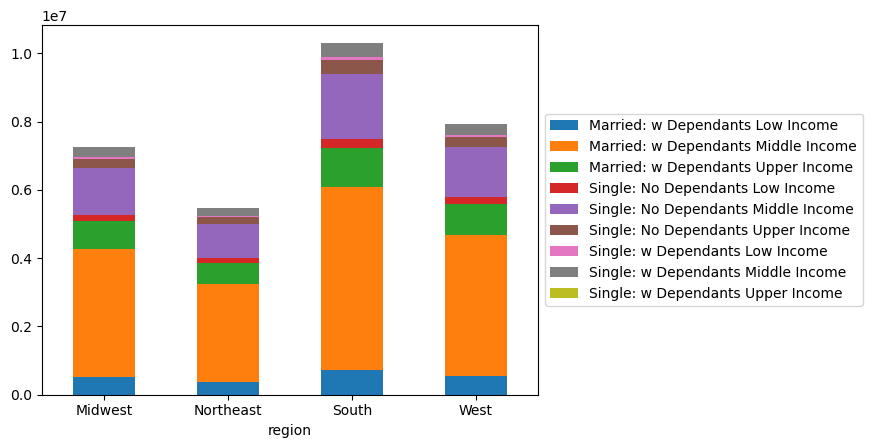

In [112]:
barplot_region_household_income = crosstab3.plot.bar(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [106]:
barplot_region_household_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_region_household_income.png'), bbox_inches='tight')

In [108]:
#validating if region impacts products bought using crosstab
crosstab_region_department = pd.crosstab(ha_ords_prods_custs['region'],ha_ords_prods_custs['department'],dropna=False)

In [109]:
crosstab_region_department

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
region,,,,,,,,,,,,,,,,,,,,,
Midwest,34043,95741,261753,598979,156155,7929,237459,1212490,234464,193463,...,166992,60666,158260,15563,7983,420334,100398,21358,2134115,645143
Northeast,25017,72712,199300,462929,117904,5599,176936,914616,178398,143817,...,124604,44678,118571,11512,6268,312731,74765,17734,1593004,493154
South,48813,139511,371620,859419,223172,11180,337458,1723016,333620,272813,...,230061,84649,224120,21787,11579,591754,142496,29909,3027476,916780
West,36754,102428,288155,650574,173619,8743,260221,1327060,257352,212043,...,178200,65998,173830,15906,8581,457886,106647,24059,2324678,711329


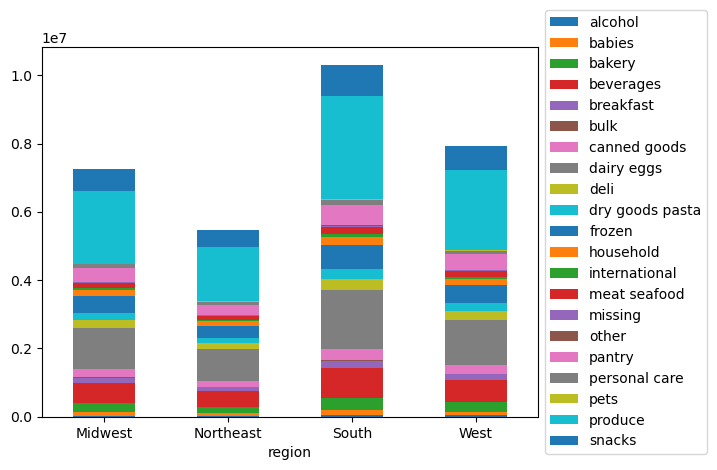

In [111]:
barplot_region_department_income = crosstab_region_department.plot.bar(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [113]:
barplot_region_department_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_region_department_income.png'), bbox_inches='tight')

#### Observation: As with the age_income chart above, the household_income chart follows the same distribution of groupings across regions. Each region has a near identical proportions of groupings. Whilst we already knew from our value_counts() of the household_income variable that the 'Married w/ dependants middle income' grouping made up approx. 50% of the data, it's curious seeing how evenly distibuted it is no matter which region is being discussed. Proportionally, each region appears to have 50% or so of their customer base falling in this grouping.

In [56]:
crosstab4 = pd.crosstab(ha_ords_prods_custs['department'],ha_ords_prods_custs['age_income_combined'],dropna=False)

In [57]:
crosstab4

age_income_combined,Middle Age Low Income,Middle Age Middle Income,Middle Age Upper Income,Old Age Low Income,Old Age Middle Income,Old Age Upper Income,Young Low Income,Young Middle Income,Young Upper Income
department,,,,,,,,,
alcohol,3757,30248,11370,4300,30116,13180,8794,40016,2846
babies,5812,94408,29978,5930,98532,34276,15288,125479,689
bakery,24326,247518,80536,24619,265933,91894,50923,329934,5145
beverages,90566,552027,171466,100264,588725,194680,170031,695021,9121
breakfast,21381,144418,45361,23346,152553,51852,41390,187989,2560
bulk,1243,7041,2119,1099,8017,2308,1982,9629,13
canned goods,16790,227251,73870,17616,244762,82069,39188,306363,4165
dairy eggs,113101,1141893,366373,117846,1234403,410263,238296,1536634,18373
deli,24824,219968,69862,24588,239568,79179,50414,292806,2625


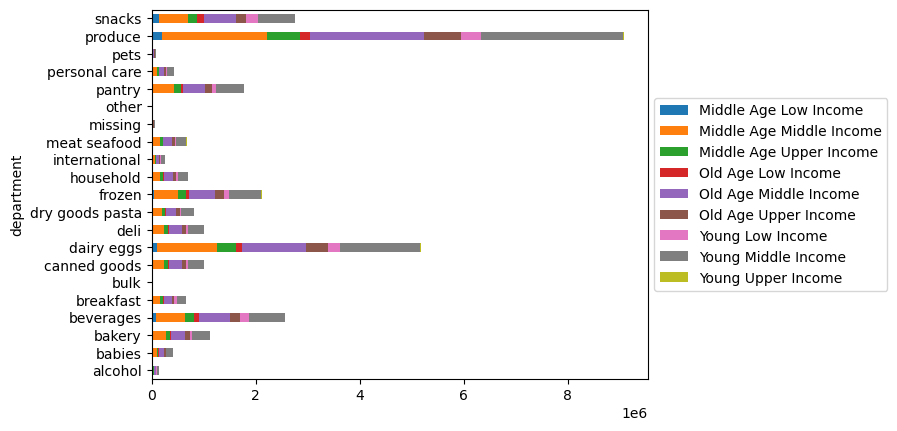

In [58]:
barplot_department_age_income = crosstab4.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [59]:
barplot_department_age_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_department_age_income.png'), bbox_inches='tight')

In [60]:
crosstab5 = pd.crosstab(ha_ords_prods_custs['department'],ha_ords_prods_custs['household_income_combined'],dropna=False)

In [61]:
crosstab5

household_income_combined,Married: w Dependants Low Income,Married: w Dependants Middle Income,Married: w Dependants Upper Income,Single: No Dependants Low Income,Single: No Dependants Middle Income,Single: No Dependants Upper Income,Single: w Dependants Low Income,Single: w Dependants Middle Income,Single: w Dependants Upper Income
department,,,,,,,,,
alcohol,11427,68134,19860,3992,25769,7066,1432,6477,470
babies,18532,221652,47499,6796,79202,17330,1702,17565,114
bakery,68713,584322,132714,24641,212532,44222,6514,46531,639
beverages,248776,1279598,279079,89932,460415,94994,22153,95760,1194
breakfast,58982,337456,74782,21323,120467,24642,5812,27037,349
bulk,3088,17440,3290,953,5899,1148,283,1348,2
canned goods,49852,543172,119553,18425,192685,39910,5317,42519,641
dairy eggs,317454,2724398,590747,120041,972870,201465,31748,215662,2797
deli,67504,522091,112738,25589,189263,38530,6733,40988,398


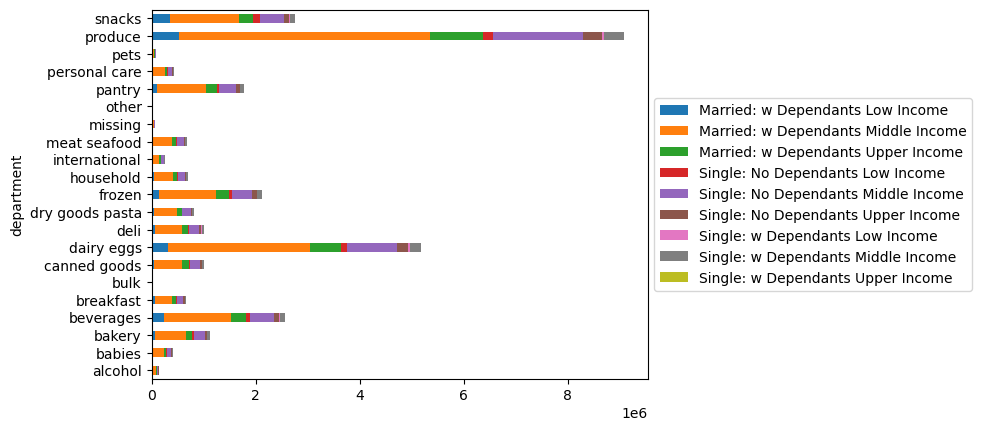

In [62]:
barplot_department_household_income = crosstab5.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [63]:
barplot_department_household_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_department_household_income.png'), bbox_inches='tight')

### Part 4. c) How do Cx profiles impact spending habits and loyalty?

#### - Loyalty

In [64]:
crosstab6 = pd.crosstab(ha_ords_prods_custs['age_income_combined'],ha_ords_prods_custs['loyalty_flag'],dropna=False)

In [65]:
crosstab6

loyalty_flag,Loyal customer,New customer,Regular customer
age_income_combined,,,
Middle Age Low Income,239575,152381,389794
Middle Age Middle Income,2300882,1040330,3449896
Middle Age Upper Income,709477,321275,1121340
Old Age Low Income,252334,147955,405210
Old Age Middle Income,2443766,1134137,3757984
Old Age Upper Income,818673,367883,1246562
Young Low Income,471490,289636,797749
Young Middle Income,3005521,1338924,4656910
Young Upper Income,42375,11174,51331


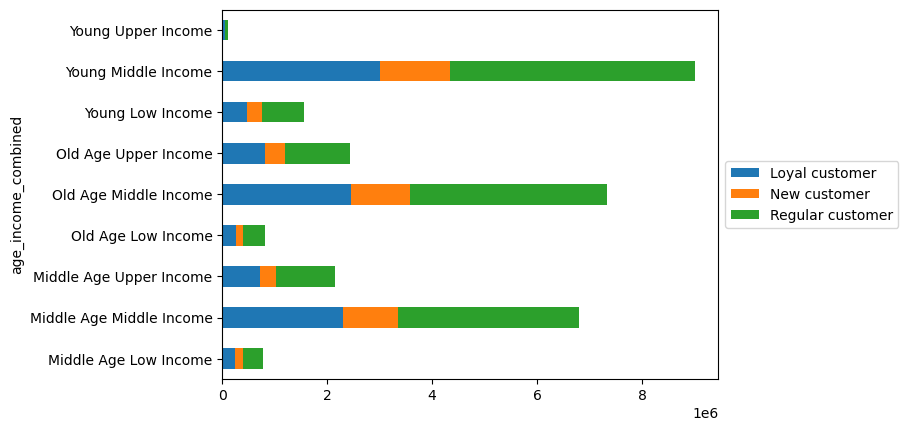

In [66]:
barplot_loyalty_age_income = crosstab6.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [67]:
barplot_loyalty_age_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_loyalty_age_income.png'), bbox_inches='tight')

In [68]:
crosstab7 = pd.crosstab(ha_ords_prods_custs['household_income_combined'],ha_ords_prods_custs['loyalty_flag'],dropna=False)

In [69]:
crosstab7

loyalty_flag,Loyal customer,New customer,Regular customer
household_income_combined,,,
Married: w Dependants Low Income,661309,402920,1086429
Married: w Dependants Middle Income,5389773,2455026,8262399
Married: w Dependants Upper Income,1151418,522705,1811732
Single: No Dependants Low Income,245817,148456,394644
Single: No Dependants Middle Income,1931275,875895,2954688
Single: No Dependants Upper Income,411752,176914,600240
Single: w Dependants Low Income,56273,38596,111680
Single: w Dependants Middle Income,429121,182470,647703
Single: w Dependants Upper Income,7355,713,7261


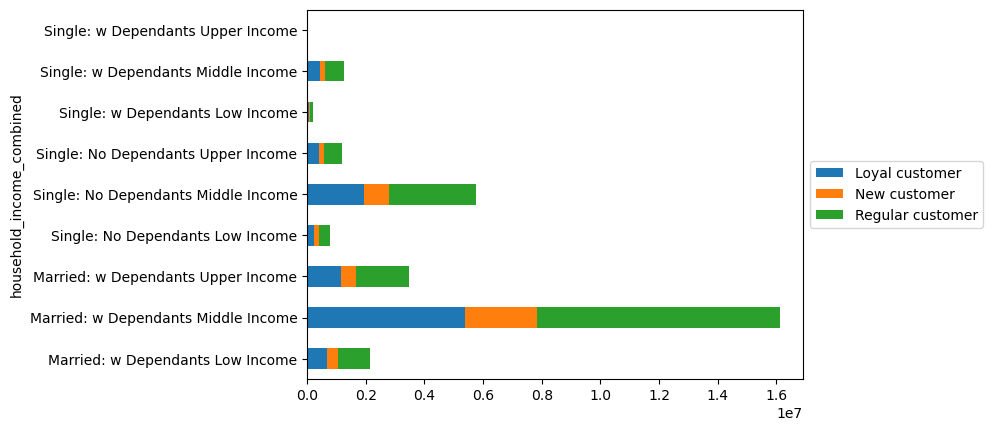

In [70]:
barplot_loyalty_household_income = crosstab7.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [71]:
barplot_loyalty_household_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_loyalty_household_income'), bbox_inches='tight')

In [127]:
#lastly for loyalty, it has been requested that we see if loyalty impacts department order types - crosstabing loaylty_flag and department should yield the required results
crosstab_loyalty_department = pd.crosstab(ha_ords_prods_custs['loyalty_flag'],ha_ords_prods_custs['department'],dropna=False)


In [128]:
crosstab_loyalty_department

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
loyalty_flag,,,,,,,,,,,,,,,,,,,,,
Loyal customer,38723,167108,379873,855017,221577,13834,294594,1830707,324046,242580,...,196873,78394,202480,18350,10715,560402,123365,25469,3147376,943150
New customer,28629,46708,172104,396649,106179,4149,180196,750056,158335,144836,...,128117,43841,112464,12713,5839,299576,75442,15880,1336604,413107
Regular customer,77275,196576,568851,1320235,343094,15468,537284,2596419,521453,434720,...,374867,133756,359837,33705,17857,922727,225499,51711,4595293,1410149


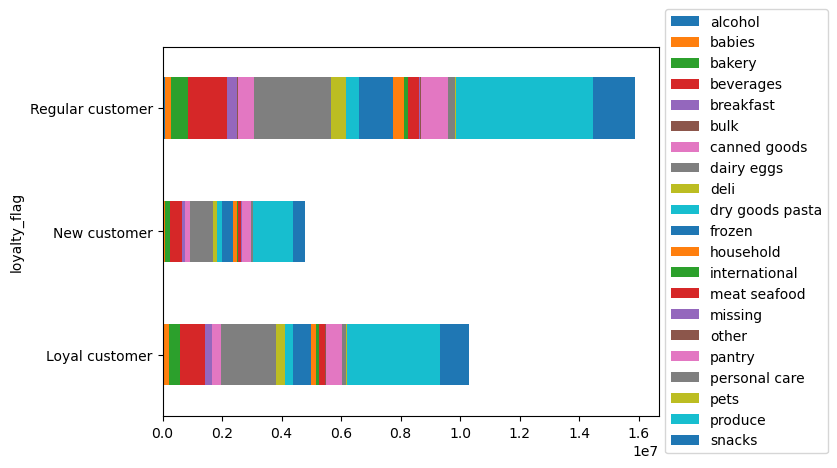

In [129]:
barplot_loyalty_department = crosstab_loyalty_department.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [130]:
barplot_loyalty_department.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_loyalty_department'), bbox_inches='tight')

#### - Spend Type

In [72]:
crosstab8 = pd.crosstab(ha_ords_prods_custs['age_income_combined'],ha_ords_prods_custs['cx_spend_type'],dropna=False)

In [73]:
crosstab8

cx_spend_type,High spender,Low spender
age_income_combined,,
Middle Age Low Income,133,781617
Middle Age Middle Income,49138,6741970
Middle Age Upper Income,146122,2005970
Old Age Low Income,0,805499
Old Age Middle Income,58712,7277175
Old Age Upper Income,148456,2284662
Young Low Income,1183,1557692
Young Middle Income,94801,8906554
Young Upper Income,104880,0


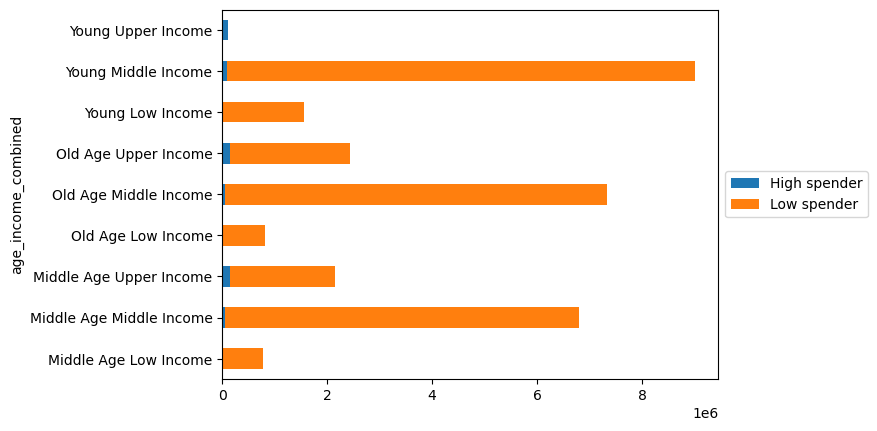

In [74]:
barplot_spend_age_income = crosstab8.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [75]:
barplot_spend_age_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_spend_age_income'), bbox_inches='tight')

In [76]:
crosstab9 = pd.crosstab(ha_ords_prods_custs['household_income_combined'],ha_ords_prods_custs['cx_spend_type'],dropna=False)

In [77]:
crosstab9

cx_spend_type,High spender,Low spender
household_income_combined,,
Married: w Dependants Low Income,981,2149677
Married: w Dependants Middle Income,141959,15965239
Married: w Dependants Upper Income,286517,3199338
Single: No Dependants Low Income,246,788671
Single: No Dependants Middle Income,48184,5713674
Single: No Dependants Upper Income,97612,1091294
Single: w Dependants Low Income,89,206460
Single: w Dependants Middle Income,12508,1246786
Single: w Dependants Upper Income,15329,0


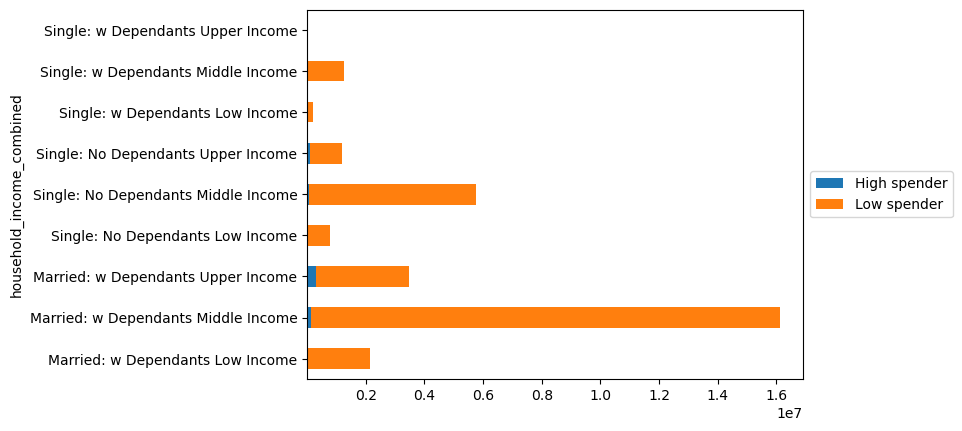

In [78]:
barplot_spend_household_income = crosstab9.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [79]:
barplot_spend_household_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_spend_household_income.png'), bbox_inches='tight')

In [123]:
#an additional comparision to make is how loyalty impacts spend type - we know that all regions share the same client profile distributions, so we can assume that any loyalty/spend comparisions apply on a regional basis too.
crosstab_loyalty_spend_type = pd.crosstab(ha_ords_prods_custs['loyalty_flag'],ha_ords_prods_custs['cx_spend_type'],dropna=False)

In [124]:
crosstab_loyalty_spend_type

cx_spend_type,High spender,Low spender
loyalty_flag,,
Loyal customer,216600,10067493
New customer,84011,4719684
Regular customer,302814,15573962


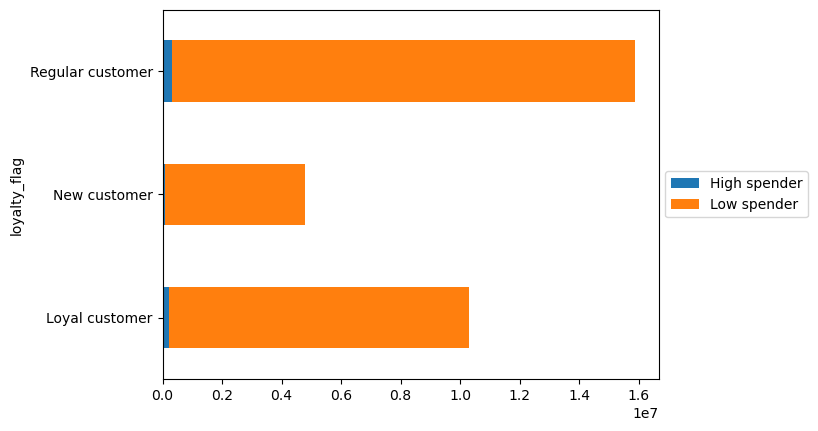

In [125]:
barplot_loyalty_spend = crosstab_loyalty_spend_type.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [126]:
barplot_loyalty_spend.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_loyalty_spend.png'), bbox_inches='tight')

#### order frequency type

In [139]:
crosstab_household_freqency = pd.crosstab(ha_ords_prods_custs['household_income_combined'],ha_ords_prods_custs['cx_frequency_type'],dropna=False)

In [140]:
crosstab_household_freqency

cx_frequency_type,Frequent customer,Non-frequent customer,Regular customer
household_income_combined,,,
Married: w Dependants Low Income,1404879,243482,502297
Married: w Dependants Middle Income,11077058,1484965,3545175
Married: w Dependants Upper Income,2406888,311376,767591
Single: No Dependants Low Income,511961,86866,190090
Single: No Dependants Middle Income,3948726,524437,1288695
Single: No Dependants Upper Income,824450,105203,259253
Single: w Dependants Low Income,136582,23542,46425
Single: w Dependants Middle Income,880912,114715,263667
Single: w Dependants Upper Income,13020,389,1920


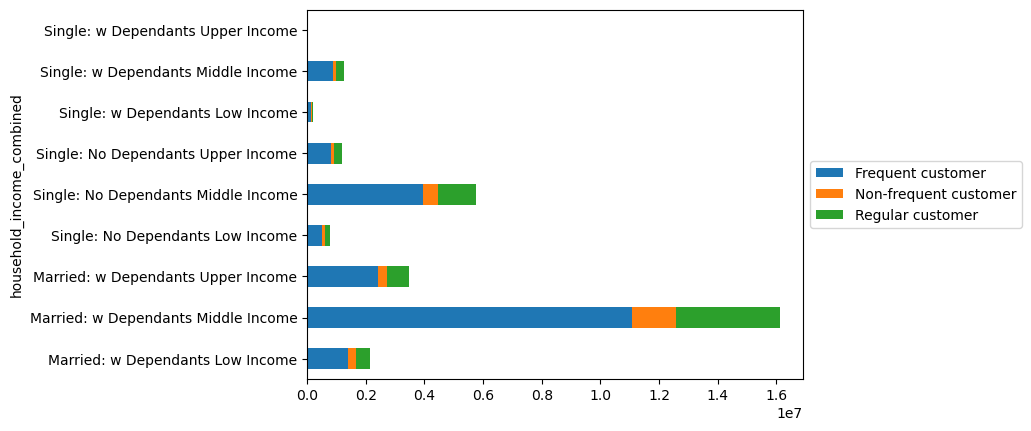

In [141]:
barplot_household_freqency = crosstab_household_freqency.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [142]:
barplot_household_freqency.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_household_freqency.png'), bbox_inches='tight')

In [143]:
crosstab_age_income_freqency = pd.crosstab(ha_ords_prods_custs['age_income_combined'],ha_ords_prods_custs['cx_frequency_type'],dropna=False)

In [144]:
crosstab_age_income_freqency

cx_frequency_type,Frequent customer,Non-frequent customer,Regular customer
age_income_combined,,,
Middle Age Low Income,510060,90017,181673
Middle Age Middle Income,4661339,637328,1492441
Middle Age Upper Income,1481548,190273,480271
Old Age Low Income,534381,88791,182327
Old Age Middle Income,5031218,685465,1619204
Old Age Upper Income,1686619,216282,530217
Young Low Income,1008981,175082,374812
Young Middle Income,6214139,801324,1985892
Young Upper Income,76191,10413,18276


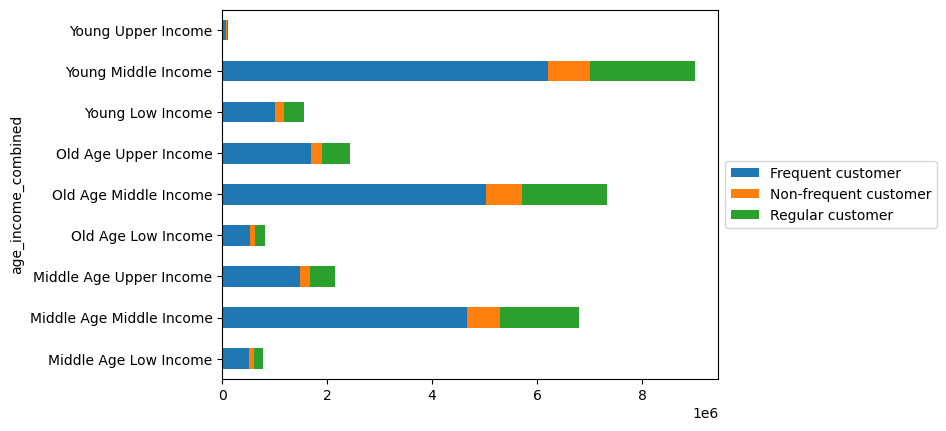

In [145]:
barplot_age_income_freqency = crosstab_age_income_freqency.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [146]:
barplot_age_income_freqency.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_age_income_freqency.png'), bbox_inches='tight')

#### As an additional point of research, are any departments bought more frequently than others (in general)? - we also need to consider price ranges of products bought (which will help us understand whether particular customer groupings are more inclined to buy premium products, or focus more on quantity over quality)

In [96]:
ha_ords_prods_custs['department'].value_counts()

department
produce            9079273
dairy eggs         5177182
snacks             2766406
beverages          2571901
frozen             2121731
pantry             1782705
bakery             1120828
canned goods       1012074
deli               1003834
dry goods pasta     822136
household           699857
meat seafood        674781
breakfast           670850
personal care       424306
babies              410392
international       255991
alcohol             144627
pets                 93060
missing              64768
other                34411
bulk                 33451
Name: count, dtype: int64

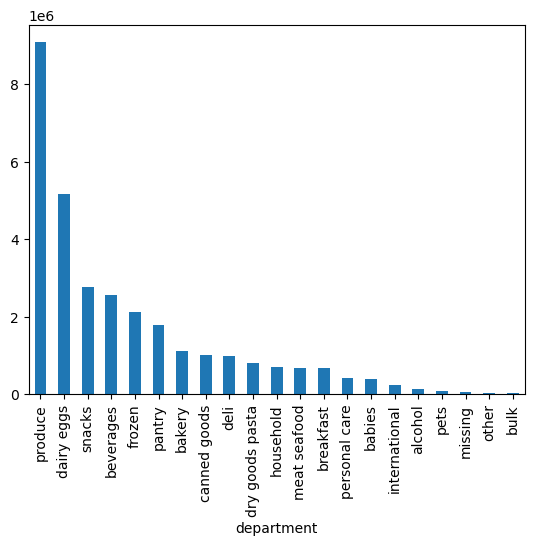

In [97]:
department_frequency = ha_ords_prods_custs['department'].value_counts().plot.bar()

In [99]:
department_frequency.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','department_frequency.png'), bbox_inches='tight')

In [102]:
#what are the prices breakdown per department?
crosstab_department_prices = pd.crosstab(ha_ords_prods_custs['department'],ha_ords_prods_custs['price_range_loc'],dropna=False)

In [103]:
crosstab_department_prices

price_range_loc,High-range product,Low-range product,Mid-range product
department,,,
alcohol,0,33046,111581
babies,0,121484,288908
bakery,0,274986,845842
beverages,0,814697,1757204
breakfast,0,209185,461665
bulk,0,1181,32270
canned goods,0,281711,730363
dairy eggs,4877,1370908,3801397
deli,0,299220,704614


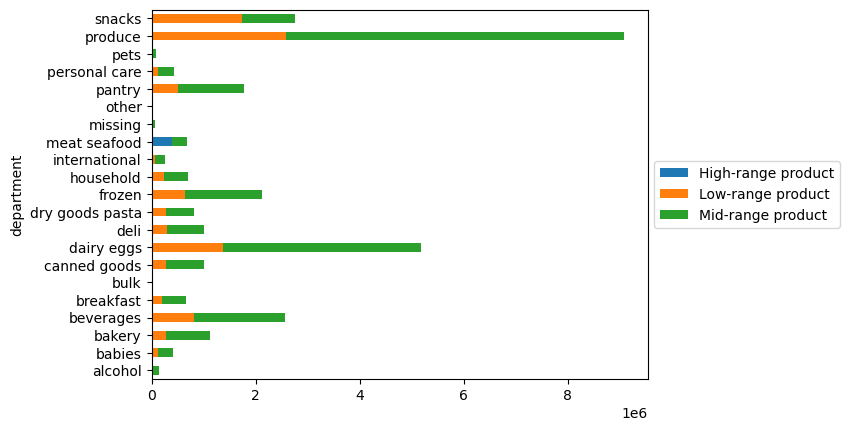

In [104]:
barplot_department_prices = crosstab_department_prices.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [105]:
barplot_department_prices.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_department_prices.png'), bbox_inches='tight')

In [81]:
#We had previously generated a value that can be used to group price brackets - we can use this product bracket description with a crosstab
ha_ords_prods_custs['price_range_loc'].value_counts()

price_range_loc
Mid-range product     20891771
Low-range product      9674840
High-range product      397953
Name: count, dtype: int64

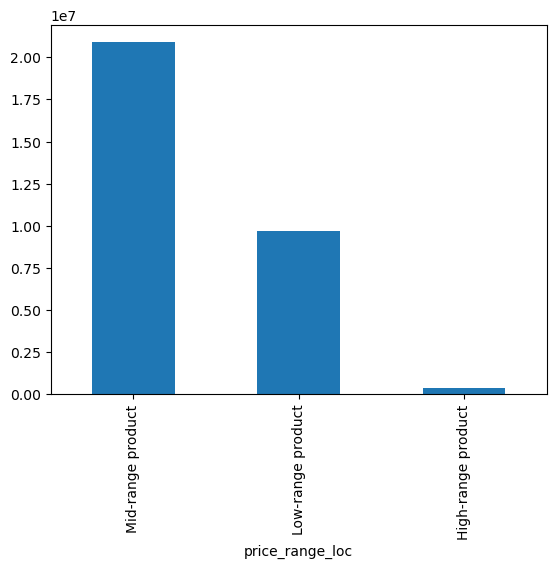

In [94]:
prod_range_table = ha_ords_prods_custs['price_range_loc'].value_counts().plot.bar()

In [100]:
prod_range_table.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','prod_range_table.png'), bbox_inches='tight')

In [82]:
#Now we need to crosstab the variable with our previous customer profile groupings to understand their product pricing choices
crosstab10 = pd.crosstab(ha_ords_prods_custs['household_income_combined'],ha_ords_prods_custs['price_range_loc'],dropna=False)

In [83]:
crosstab10

price_range_loc,High-range product,Low-range product,Mid-range product
household_income_combined,,,
Married: w Dependants Low Income,10635,897071,1242952
Married: w Dependants Middle Income,219711,4857671,11029816
Married: w Dependants Upper Income,51155,1039053,2395647
Single: No Dependants Low Income,3951,327855,457111
Single: No Dependants Middle Income,77001,1736450,3948407
Single: No Dependants Upper Income,16503,354933,817470
Single: w Dependants Low Income,1285,82923,122341
Single: w Dependants Middle Income,17361,374396,867537
Single: w Dependants Upper Income,351,4488,10490


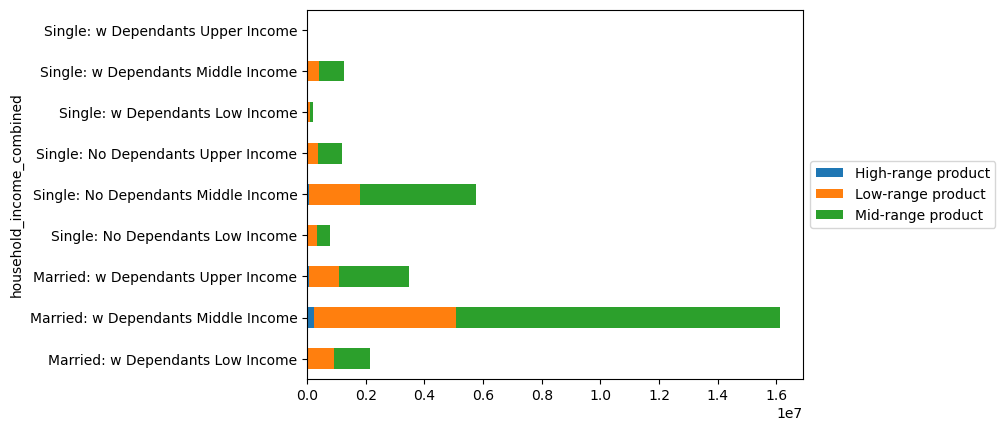

In [84]:
barplot_productprice_household_income = crosstab10.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [85]:
barplot_productprice_household_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_productprice_household_income.png'), bbox_inches='tight')

#### These results are rather useful in that they illustrate the breakdown of product prices ordered by each cx profile. Whilst the scale doesn't fully help demonstrate the disparity, it's interesting to see how the high and low price brackets fair. Whilst it's not a surprise that regular price products contribute to the majority of every shop, it's intriguing to see that regardless of income groupings and household type, there isn't a single grouping who has a tendancy to purchase more higher priced offerings. One may have guessed that 'upper income' families may have splurged on higher priced goods (or higher quality goods) from time to time, bu the proportion is far smaller than anticipated.

In [86]:
crosstab11 = pd.crosstab(ha_ords_prods_custs['age_income_combined'],ha_ords_prods_custs['price_range_loc'],dropna=False)

In [87]:
crosstab11

price_range_loc,High-range product,Low-range product,Mid-range product
age_income_combined,,,
Middle Age Low Income,3053,336498,442199
Middle Age Middle Income,91396,2059342,4640370
Middle Age Upper Income,30695,642542,1478855
Old Age Low Income,3058,347143,455298
Old Age Middle Income,99232,2230964,5005691
Old Age Upper Income,34642,723937,1674539
Young Low Income,9760,624208,924907
Young Middle Income,123445,2678211,6199699
Young Upper Income,2672,31995,70213


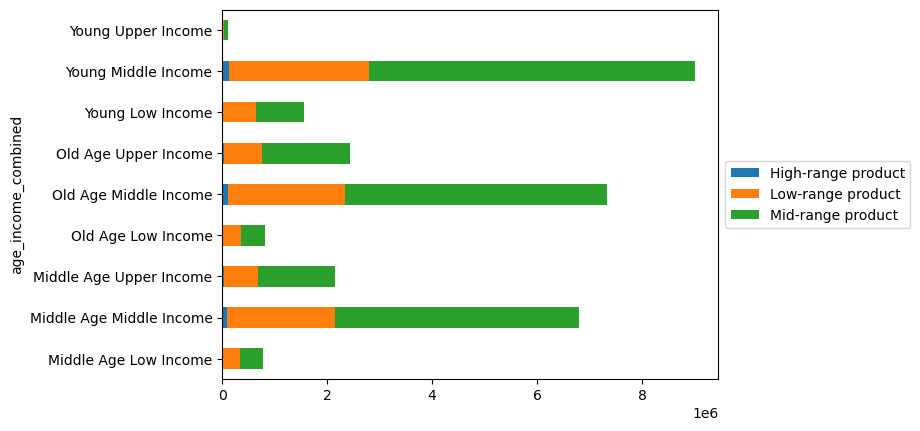

In [88]:
barplot_productprice_age_income = crosstab11.plot.barh(stacked=True, legend=True,rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [89]:
barplot_productprice_age_income.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','barplot_productprice_age_income.png'), bbox_inches='tight')

#### When looking at age rather than household customer groupings, the product price bracket breakdown tells the same story - regular priced' items are always popular, but even in middle and upper income groupings, the remaing split between high and low priced products demonstrates that regardless of income, cheaper essentials are always purchased, whilst higher priced goods are an after thought

In [92]:
ha_ords_prods_custs.shape

(30964564, 40)

In [91]:
#exporting final version of file for stakeholders who are interested:
ha_ords_prods_custs.to_pickle(os.path.join(path,'02 Data','Prepared Data','Final_Instacart_Order_Data.pkl'))